<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/041_GAN_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎨 GAN: Wojna Sieci (Generator vs Dyskryminator)

W GAN-ie mamy dwóch graczy:

1.  **Generator (Fałszerz):**
    *   Dostaje losowy szum (przypadkowe liczby).
    *   Jego zadaniem jest stworzyć z tego obrazek, który oszuka Policjanta.
    *   *Cel:* Sprawić, by Policjant powiedział "To oryginał".

2.  **Dyskryminator (Policjant):**
    *   Dostaje obrazki prawdziwe (z bazy danych) i fałszywe (od Generatora).
    *   Jego zadaniem jest je odróżnić.
    *   *Cel:* Bezbłędnie wykrywać fałszywki.

Trenują się nawzajem. Im lepszy jest Fałszerz, tym lepszy musi być Policjant (i odwrotnie).
Użyjemy zbioru **MNIST** (cyfry), żeby nauczyć sieć pisać ręcznie.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
BATCH_SIZE = 64
LR = 0.0002 # GAN-y lubią mały Learning Rate
EPOCHS = 50  # Żeby zobaczyć efekt, trzeba trochę potrenować
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. DANE (MNIST)
# Transformujemy: Zamiana na Tensor + Normalizacja do zakresu [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Ważne dla Tanh w Generatorze
])

dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Dane gotowe. Urządzenie: {DEVICE}")

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 196kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 18.4MB/s]

Dane gotowe. Urządzenie: cuda


## Budowa Graczy

1.  **Generator:**
    *   Wejście: Wektor losowy (np. 64 liczby) -> tzw. Latent Space.
    *   Warstwy: Linear -> ReLU.
    *   Wyjście: Obrazek 28x28 (784 piksele).
    *   **Ważne:** Na końcu używamy `Tanh`, żeby piksele były w zakresie [-1, 1].

2.  **Dyskryminator:**
    *   Wejście: Obrazek 28x28 (784 piksele).
    *   Warstwy: Linear -> LeakyReLU (lepiej działa w GAN).
    *   Wyjście: Jedna liczba (Prawdopodobieństwo: 1=Prawda, 0=Fałsz).
    *   **Ważne:** Na końcu `Sigmoid`.

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, img_dim=28*28):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_dim),
            nn.Tanh()  # Wyjście -1 do 1
        )

    def forward(self, x):
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2), # Leaky jest stabilniejsze w GAN
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # Prawdopodobieństwo (0-1)
        )

    def forward(self, x):
        return self.disc(x)

# Inicjalizacja
z_dim = 64
generator = Generator(z_dim).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# DWA optymalizatory (bo trenujemy dwie osobne sieci!)
opt_gen = optim.Adam(generator.parameters(), lr=LR)
opt_disc = optim.Adam(discriminator.parameters(), lr=LR)

# Funkcja kosztu (Binary Cross Entropy)
criterion = nn.BCELoss()

print("Armie gotowe do walki.")

Armie gotowe do walki.


## Pętla Treningowa (Wojna)

To jest najtrudniejsza część. W każdej pętli:

1.  **Trenujemy Dyskryminatora:**
    *   Pokazujemy mu prawdziwe zdjęcia (wymagamy 1).
    *   Pokazujemy mu fałszywki wygenerowane przez Generator (wymagamy 0).
    *   Liczymy błąd i poprawiamy Policjanta.

2.  **Trenujemy Generatora:**
    *   Generujemy fałszywki.
    *   Pokazujemy je Policjantowi.
    *   **Haczyk:** Chcemy, żeby Policjant powiedział 1 (oszukujemy go!).
    *   Liczymy błąd i poprawiamy Fałszerza.

In [3]:
# Lista do przechowywania postępów
fixed_noise = torch.randn(9, z_dim).to(DEVICE) # Stały szum do wizualizacji (żeby widzieć jak te same liczby zmieniają się w cyfry)
step = 0

print("Rozpoczynam trening (To potrwa chwilę)...")

for epoch in range(EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        # Przygotowanie danych
        real = real.view(-1, 28*28).to(DEVICE) # Spłaszczamy obrazek [Batch, 784]
        batch_size = real.shape[0]
        
        ### 1. TRENING DYSKRYMINATORA (POLICJANT) ###
        # Generujemy szum
        noise = torch.randn(batch_size, z_dim).to(DEVICE)
        fake = generator(noise) # Fałszywki
        
        # Ocena prawdziwych (chcemy same jedynki)
        disc_real = discriminator(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        
        # Ocena fałszywych (chcemy same zera)
        disc_fake = discriminator(fake.detach()).view(-1) # .detach() bo nie chcemy tu ruszać generatora
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        # Średnia strata i Backprop
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward()
        opt_disc.step()
        
        ### 2. TRENING GENERATORA (FAŁSZERZ) ###
        # Oceniamy fałszywki jeszcze raz (tym razem chcemy oszukać)
        output = discriminator(fake).view(-1)
        
        # CHCEMY JEDYNKI (Oszustwo udane)
        loss_gen = criterion(output, torch.ones_like(output))
        
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    # Wypisz status co epokę
    print(f"Epoka [{epoch+1}/{EPOCHS}] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

Rozpoczynam trening (To potrwa chwilę)...
Epoka [1/50] Loss D: 0.0392, Loss G: 6.1809
Epoka [2/50] Loss D: 0.0397, Loss G: 4.3559
Epoka [3/50] Loss D: 0.0565, Loss G: 5.0640
Epoka [4/50] Loss D: 0.1205, Loss G: 3.8098
Epoka [5/50] Loss D: 0.0328, Loss G: 4.5987
Epoka [6/50] Loss D: 0.0770, Loss G: 5.9645
Epoka [7/50] Loss D: 0.1007, Loss G: 3.8638
Epoka [8/50] Loss D: 0.0501, Loss G: 5.9103
Epoka [9/50] Loss D: 0.0563, Loss G: 5.2520
Epoka [10/50] Loss D: 0.0550, Loss G: 6.1423
Epoka [11/50] Loss D: 0.0854, Loss G: 5.8798
Epoka [12/50] Loss D: 0.1333, Loss G: 6.1480
Epoka [13/50] Loss D: 0.0875, Loss G: 3.9156
Epoka [14/50] Loss D: 0.1155, Loss G: 3.7276
Epoka [15/50] Loss D: 0.1573, Loss G: 3.9109
Epoka [16/50] Loss D: 0.1730, Loss G: 3.7711
Epoka [17/50] Loss D: 0.1179, Loss G: 2.9496
Epoka [18/50] Loss D: 0.1138, Loss G: 3.3292
Epoka [19/50] Loss D: 0.3067, Loss G: 2.8603
Epoka [20/50] Loss D: 0.1778, Loss G: 3.9118
Epoka [21/50] Loss D: 0.1869, Loss G: 2.9590
Epoka [22/50] Loss D: 

--- CO STWORZYŁ GENERATOR? ---


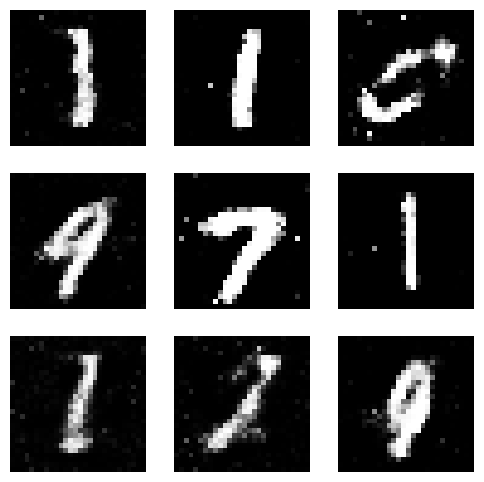

In [4]:
# WIZUALIZACJA WYNIKÓW
print("--- CO STWORZYŁ GENERATOR? ---")

with torch.no_grad():
    fake_images = generator(fixed_noise).reshape(-1, 1, 28, 28)
    fake_images = fake_images.cpu().detach() # Przenosimy na CPU do rysowania

# Rysujemy siatkę 3x3
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(fake_images[i][0], cmap='gray')
    ax.axis('off')
plt.show()

## 🧠 Podsumowanie: Równowaga Nasha

Jeśli na obrazkach widzisz coś przypominającego cyfry (nawet zamazane), to sukces!

**Tu jest haczyk (Stabilność).**
GAN-y są niezwykle trudne w treningu.
*   Jeśli Dyskryminator będzie za mądry -> Generator nigdy go nie oszuka, zniechęci się i przestanie uczyć (Gradient Vanishing).
*   Jeśli Dyskryminator będzie za głupi -> Generator będzie tworzył byle co, a i tak wygra.

Idealny stan to **Równowaga**, gdzie Policjant ma 50% skuteczności (zgaduje losowo), bo Fałszerz tworzy idealne kopie.